In [1]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Load Data

In [2]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)
sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
test_df_row = test_df.shape[0]
test_df_col = test_df.shape[1]

print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))
print('Testing DataFrame: {} rows & {} columns.'.format(test_df_row, test_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.
Testing DataFrame: 506691 rows & 433 columns.


In [3]:
# release data from those four
del train_transaction
del train_identity
# del test_transaction
# del test_identity

In [4]:
train_is_fraud = train_df[train_df['isFraud']==1].sample(replace=True, n=10*len(train_df[train_df['isFraud']==1]))
train_is_not_fraud = train_df[train_df['isFraud']==0].sample(n=len(train_is_fraud))
train_df = pd.concat([train_is_fraud, train_is_not_fraud])

### Time

In [5]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [6]:
print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#addr1, addr2
top_ten_addr1 = list(train_df['addr1'].value_counts().index)[:100] #top ten regions
top_ten_addr2 = list(train_df['addr2'].value_counts().index)[:100] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

#Email_Domain
top_twenty_email_p = list(train_df['P_emaildomain'].value_counts().index)[:50] #top ten regions
top_twenty_email_r = list(train_df['R_emaildomain'].value_counts().index)[:50] #top ten countries
train_df['P_emaildomain'].value_counts()
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

86401


In [7]:
### new added
#device info
def device_info_transform(x):
    if x in top_device_info:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
top_device_info = list(train_df['DeviceInfo'].value_counts().index)[:100] #top device info
train_df['DeviceInfo_new'] = train_df['DeviceInfo'].apply(device_info_transform)


id_lst = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 
               'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33']

new_id_lst = [i + '_new' for i in id_lst]

top_i_lst = []

def transform_i(x):
    if x in top_i:
        return str(x)
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
        
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:12]
    print(top_i)
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)   

[-5.0, -20.0, -10.0, 0.0, -15.0, -25.0, -35.0, -45.0, -100.0, -50.0, -40.0, -30.0]
[0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0]
[0.0, -8.0, -11.0, -12.0, -5.0, -6.0, -13.0, -10.0, -4.0, -2.0, -9.0, -7.0]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -3.0, -5.0, 9.0]
[0.0, -1.0, -5.0, -9.0, -6.0, -10.0, -100.0, -8.0, -11.0, -12.0, -13.0, -7.0]
[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0]
[0.0, -11.0, -8.0, -5.0, -6.0, -13.0, -12.0, -10.0, -4.0, -9.0, -1.0, -2.0]
[100.0, 95.08000183105467, 96.66999816894533, 95.16000366210938, 97.13999938964844, 97.12000274658205, 96.72000122070312, 95.6500015258789, 94.29000091552734, 93.5500030517578, 96.19000244140624, 96.47000122070312]
[52.0, 49.0, 64.0, 33.0, 27.0, 20.0, 43.0, 19.0, 14.0, 24.0, 25.0, 63.0]
[-300.0, -360.0, -480.0, -420.0, -180.0, 0.0, 60.0, -240.0, -600.0, 120.0, 480.0, -540.0]
[225.0, 166.0, 102.0, 100.0, 110.0, 159.0, 148.0, 121.0, 106.0, 142.0, 114.0, 214.0]
[266.0, 427.0, 410.0, 153.0

In [8]:
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:12]
    print(top_i)
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)  

[-5.0, -20.0, -10.0, 0.0, -15.0, -25.0, -35.0, -45.0, -100.0, -50.0, -40.0, -30.0]
[0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0]
[0.0, -8.0, -11.0, -12.0, -5.0, -6.0, -13.0, -10.0, -4.0, -2.0, -9.0, -7.0]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -3.0, -5.0, 9.0]
[0.0, -1.0, -5.0, -9.0, -6.0, -10.0, -100.0, -8.0, -11.0, -12.0, -13.0, -7.0]
[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0]
[0.0, -11.0, -8.0, -5.0, -6.0, -13.0, -12.0, -10.0, -4.0, -9.0, -1.0, -2.0]
[100.0, 95.08000183105467, 96.66999816894533, 95.16000366210938, 97.13999938964844, 97.12000274658205, 96.72000122070312, 95.6500015258789, 94.29000091552734, 93.5500030517578, 96.19000244140624, 96.47000122070312]
[52.0, 49.0, 64.0, 33.0, 27.0, 20.0, 43.0, 19.0, 14.0, 24.0, 25.0, 63.0]
[-300.0, -360.0, -480.0, -420.0, -180.0, 0.0, 60.0, -240.0, -600.0, 120.0, 480.0, -540.0]
[225.0, 166.0, 102.0, 100.0, 110.0, 159.0, 148.0, 121.0, 106.0, 142.0, 114.0, 214.0]
[266.0, 427.0, 410.0, 153.0

In [9]:
top_i_lst

[[-5.0,
  -20.0,
  -10.0,
  0.0,
  -15.0,
  -25.0,
  -35.0,
  -45.0,
  -100.0,
  -50.0,
  -40.0,
  -30.0],
 [0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0],
 [0.0, -8.0, -11.0, -12.0, -5.0, -6.0, -13.0, -10.0, -4.0, -2.0, -9.0, -7.0],
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -3.0, -5.0, 9.0],
 [0.0, -1.0, -5.0, -9.0, -6.0, -10.0, -100.0, -8.0, -11.0, -12.0, -13.0, -7.0],
 [0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, -10.0, -7.0, -6.0, -8.0, -4.0],
 [0.0, -11.0, -8.0, -5.0, -6.0, -13.0, -12.0, -10.0, -4.0, -9.0, -1.0, -2.0],
 [100.0,
  95.08000183105467,
  96.66999816894533,
  95.16000366210938,
  97.13999938964844,
  97.12000274658205,
  96.72000122070312,
  95.6500015258789,
  94.29000091552734,
  93.5500030517578,
  96.19000244140624,
  96.47000122070312],
 [52.0, 49.0, 64.0, 33.0, 27.0, 20.0, 43.0, 19.0, 14.0, 24.0, 25.0, 63.0],
 [-300.0,
  -360.0,
  -480.0,
  -420.0,
  -180.0,
  0.0,
  60.0,
  -240.0,
  -600.0,
  120.0,
  480.0,
  -540.0],
 [225.0,
  166.0,
  102.0,

In [10]:
##V
# Groupby missingness
# Groupby correlation
# Keep the column with the most unique values
v_df = train_df.iloc[:, 95:434]
v_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
268979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320346,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,600.0,600.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0
320927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
v_miss_df = pd.DataFrame(v_df.isnull().mean())
v_miss_df['col'] = v_miss_df.index
group_by_miss_perc = {}
miss_perc = list(v_miss_df[0])
miss_col = list(v_miss_df['col'])

for i in range(len(miss_perc)):
    if miss_perc[i] not in group_by_miss_perc.keys():
        group_by_miss_perc[miss_perc[i]] = [v_miss_df['col'][i]]
    else:
        group_by_miss_perc[miss_perc[i]].append(v_miss_df['col'][i])
        
miss_keys = list(group_by_miss_perc.keys())
final_col_v = []
for i in range(len(miss_keys)):
    corr = train_df[group_by_miss_perc[miss_keys[i]]].corr()
    group = []
    
    for i in corr.columns:
        sub_group = [i]
        for j in corr.columns:
            if (corr[i][j] > 0.7) and (corr[i][j] < 1):
                sub_group.append(j)
        group.append(sub_group)
    
    for i in group:
        i.sort()
    final_group = []
    
    for i in group:
        if i not in final_group:
            final_group.append(i)
            
    for i in final_group:
        if len(i) != 1:
            temp = {}
            for j in i:
                temp[j] = train_df[j].nunique()
            sorted_temp = sorted(temp.items(), key=lambda item: item[1])
            final_col_v.append(sorted_temp[-1][0])
        else:
            final_col_v.append(i[0])

In [12]:
final_col_v = list(set(final_col_v))
final_col_v.sort()

In [13]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new',
               'DeviceInfo_new', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'] + new_id_lst

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log'] + final_col_v

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
# v_data = train_df.iloc[:, 95:434].fillna(0).to_numpy()

In [14]:
cates.shape

(413260, 718)

In [15]:
nums_part = train_df[num_list].reset_index(drop=True)

In [16]:
# v = pd.DataFrame(v_data).reset_index(drop=True)

In [17]:
# nums = pd.concat([nums_part, v], axis=1)

In [18]:
X = pd.concat([nums_part, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
xxx = X.columns

In [19]:
X.shape

(413260, 870)

In [20]:
y.shape

(413260,)

In [21]:
train_df.shape

(413260, 458)

### Train Test Split

In [22]:
#Raw Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=590540)

### XGBoost Decision Tree - Raw Ratio

In [23]:
#Raw Ratio
def XGBoost_DT(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier(user_label_encoder=False, eval_metric='logloss', tree_method='hist', max_depth=3, subsample=0.5, min_child_weight=15)
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [24]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train, X_test, y_train, y_test)

[10:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "user_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [25]:
print(accuracy)

0.8351933407540048


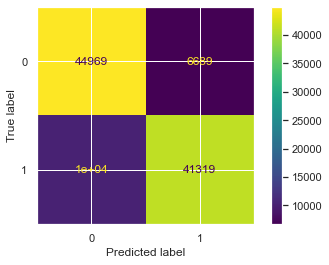

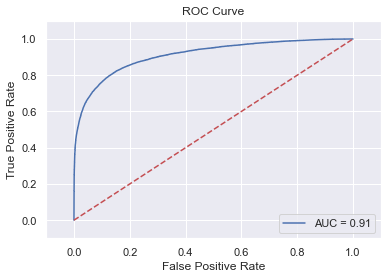

In [26]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [27]:
# ### Preparing Test Set
# test_df = test_df.drop(columns=['id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26','id_27','id_01','id_07','id_08'])

In [28]:
test_df.shape

(506691, 433)

In [29]:
#min(train_df['TransactionDT']) #86506

In [30]:
#min(test_df['TransactionDT']) #18404013

In [31]:
test_df['TransactionDT'] = test_df['TransactionDT'] - min(train_df['TransactionDT'])
test_df['TransactionDayOfWeek'] = test_df['TransactionDT'].apply(convert_day_of_week)
test_df['TransactionHour'] = test_df['TransactionDT'].apply(convert_hour)
# Transaction Amount (Log)
test_df['TransactionAmt_log'] = test_df['TransactionAmt'].apply(lambda x: np.log(x))
#addr1, addr2
top_ten_addr1 = list(test_df['addr1'].value_counts().index)[:100] #top ten regions
top_ten_addr2 = list(test_df['addr2'].value_counts().index)[:100] #top ten countries
test_df['addr1_new'] = test_df['addr1'].apply(addr1_transform)
test_df['addr2_new'] = test_df['addr2'].apply(addr2_transform)
#Email_Domain
top_twenty_email_p = list(test_df['P_emaildomain'].value_counts().index)[:50] #top ten regions
top_twenty_email_r = list(test_df['R_emaildomain'].value_counts().index)[:50] #top ten countries
test_df['P_emaildomain'].value_counts()
test_df['P_emaildomain_new'] = test_df['P_emaildomain'].apply(email_p_transform)
test_df['R_emaildomain_new'] = test_df['R_emaildomain'].apply(email_r_transform)

In [32]:
##new added
top_device_info = list(test_df['DeviceInfo'].value_counts().index)[:100] #top device info
test_df['DeviceInfo_new'] = test_df['DeviceInfo'].apply(device_info_transform)

In [33]:
test_col = [i.replace('-', '_') for i in test_df.columns]
test_df.columns = test_col

In [34]:
def transform_i_new(x, arg=i):
    if x in top_i_lst[i]:
        return str(x)
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

for i in range(len(id_lst)):
    top_i = list(test_df[id_lst[i]].value_counts().index)[:12] #top device info
    new_col = id_lst[i] + '_new'
    test_df[new_col] = test_df[id_lst[i]].apply(transform_i_new, arg=i)

In [35]:
test_df.columns = list(train_df.drop(columns=['isFraud']).columns)

In [36]:
ohe_features_test = ohe.transform(test_df[one_hot_lst])
cates_test = pd.DataFrame(ohe_features_test.toarray())
# v_data = test_df.iloc[:, 94:433].fillna(0).to_numpy()

In [37]:
nums_part = test_df[num_list]
# v = pd.DataFrame(v_data)
# nums = pd.concat([nums_part, v], axis = 1)
X = pd.concat([nums_part, cates_test], axis=1)

In [38]:

y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
preds = xgb_cl.predict(X)
test_df['isFraud'] = pd.Series(preds)
submission = test_df[['TransactionID', 'isFraud']]
submission.to_csv("submission.csv", index=False)

In [39]:
submission

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
